# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)
import pandas as pd

In [2]:
data = pd.read_excel('geo.xlsx')
data.rename(columns={'Unnamed: 0':'User_Id'},inplace=True)

In [3]:
data.head()

,User_Id,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [4]:
# Проверим на наличие дубликатов

In [5]:
len(data['User_Id'].unique()) == len(data['User_Id'])

True

In [6]:
# пропущенных значений нет

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
User_Id          108806 non-null int64
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [8]:
#  "За" и "Против"

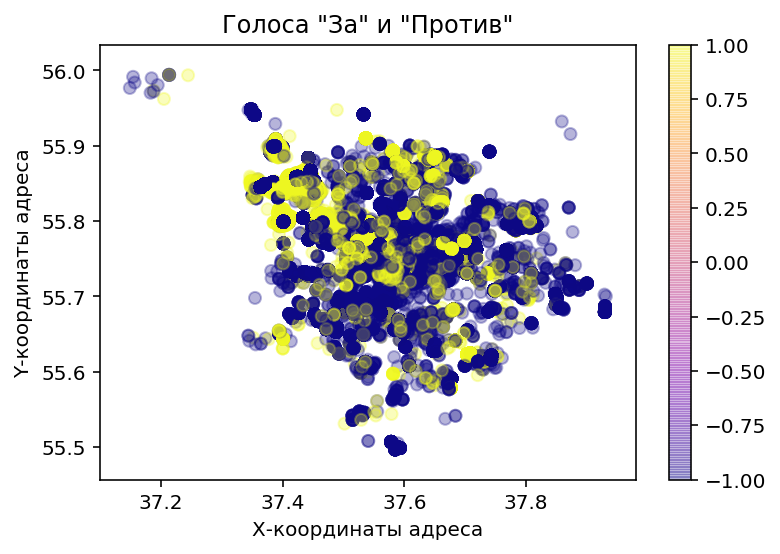

In [9]:
plt.scatter(data['x'],data['y'],c=data['comment_class'],alpha=.3,cmap='plasma')
plt.colorbar()
plt.title('Голоса \"За\" и \"Против\"')
plt.xlabel('X-координаты адреса')
plt.ylabel('Y-координаты адреса');

In [10]:
# приведём данные по обеим осям к нормальному распределению

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
xy_scaled = scaler.fit_transform(data[['x','y']])

In [14]:
xy_scaled.shape

(108806, 2)

In [15]:
data['x_scaled'] = xy_scaled[:,0]
data['y_scaled'] = xy_scaled[:,1]

In [16]:
data.drop(['x','y'],axis = 1, inplace=True)

In [17]:
data.head()

,User_Id,comment_class,x_scaled,y_scaled
0,0,-1,0.367919,0.159553
1,1,-1,0.367919,0.159553
2,2,-1,0.293178,-0.348131
3,3,-1,-0.073819,-0.539880
4,4,-1,-0.009022,-0.496273


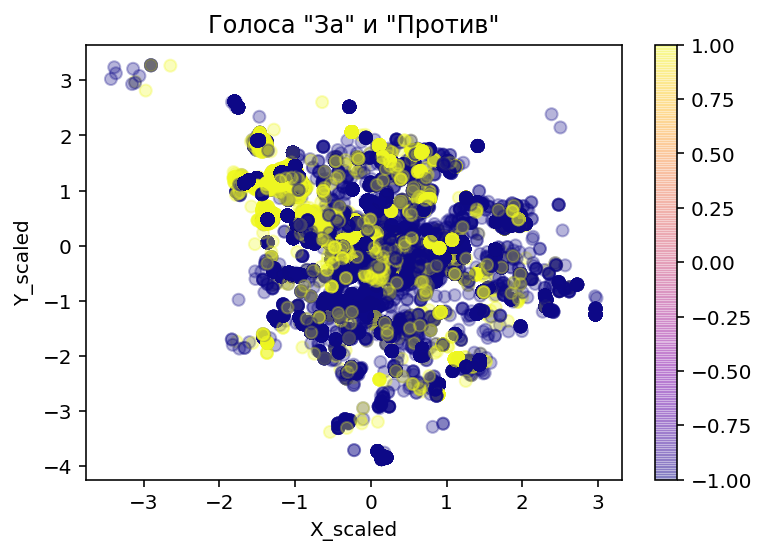

In [18]:
plt.scatter(data['x_scaled'],data['y_scaled'],c=data['comment_class'],alpha=.3,cmap='plasma')
plt.colorbar()
plt.title('Голоса \"За\" и \"Против\"')
plt.xlabel('X_scaled')
plt.ylabel('Y_scaled');

In [19]:
# форма осталась, но диапазоны выровнялись:

# Подбор количества кластеров для KMeans

KMeans минимизирует сумму квадратов расстояний объектов классов до их центроидов. В обученном классификаторе это значение находится в поле inertia_

Посчитаем значения inertia при разном количестве кластеров. Они объективно стремятся к нулю с ростом числа кластеров (предельный случай: каждый объект - кластер, расстояние = 0)

In [20]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [21]:
# проверим на 12 райнах

In [22]:
k_inertia = []
ks = range(1,13)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data[['x_scaled','y_scaled']])
    k_inertia.append(clf_kmeans.inertia_)

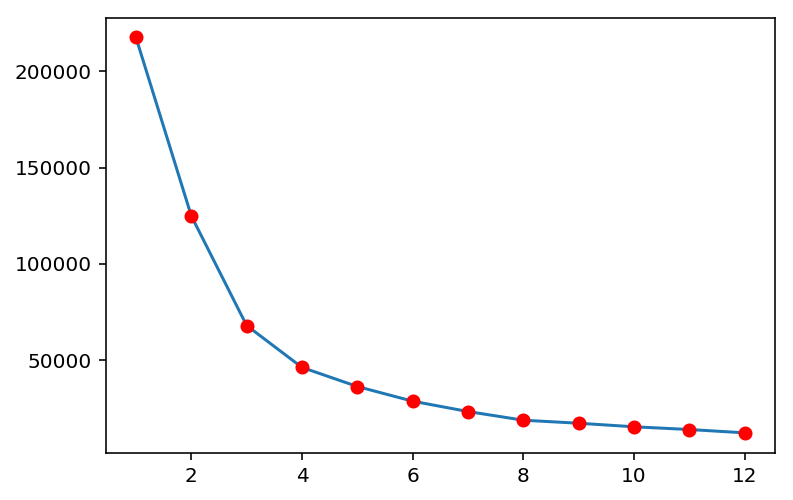

In [23]:
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro');

Как подобрать оптимальное значение? Будем на каждом шаге смотреть изменение inertia, и в тот момент, когда оно резко замедлится (относительно предыдущего изменения) мы и остановимся

Для начала считаем сами изменения

$${inertia_{k+1}-inertia_{k}}$$

In [24]:
diff = np.diff(k_inertia)

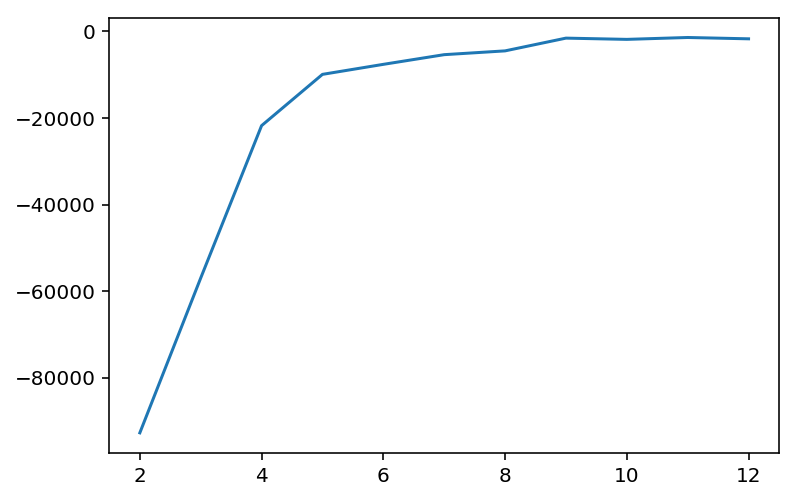

In [25]:
plt.plot(ks[1:], diff);

Теперь можно найти оптимальное число кластеров по этой формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [26]:
diff_r = diff[1:] / diff[:-1]
diff_r

array([0.61441703, 0.38227427, 0.45614635, 0.76702733, 0.70647961,
       0.83757695, 0.3469932 , 1.18387287, 0.76467499, 1.21733836])

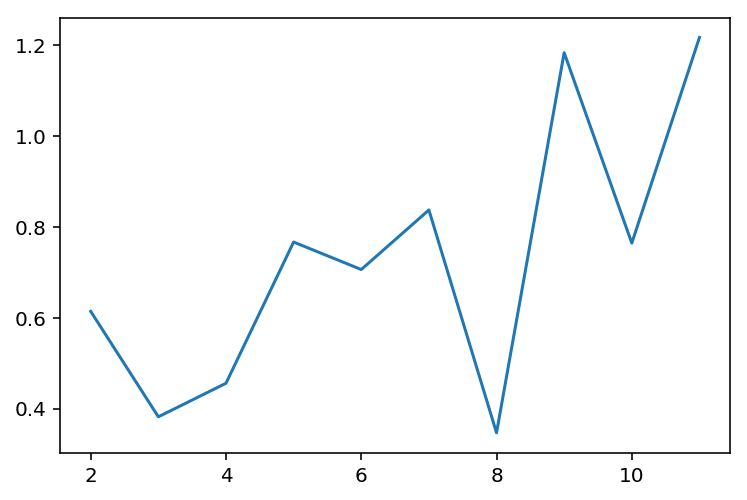

In [27]:
plt.plot(ks[1:-1], diff_r);

In [28]:
# резко замедляется на 8
k_opt = ks[np.argmin(diff_r)+1]
k_opt

8

In [29]:
clf_Kmeans = KMeans(n_clusters=8)
clusters = clf_Kmeans.fit_predict(data[['x_scaled','y_scaled']])
center = clf_Kmeans.cluster_centers_

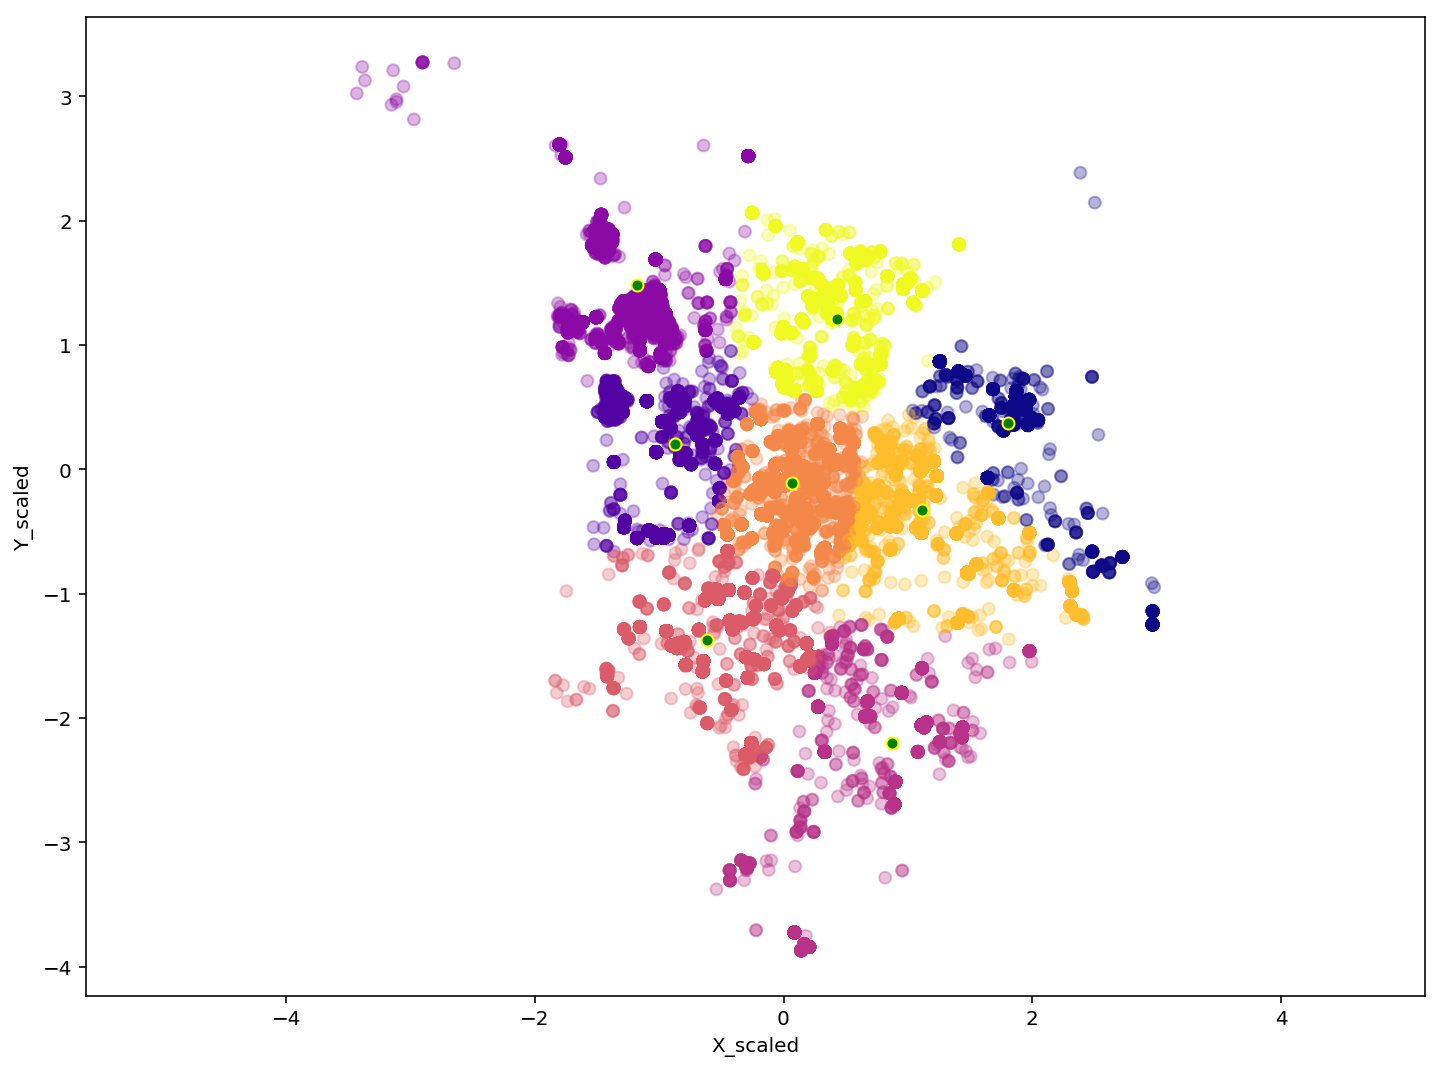

In [30]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(data['x_scaled'], data['y_scaled'],cmap='plasma',c=clusters,alpha=0.3)
ax.scatter(center[:,0],center[:,1], c='g',edgecolors='yellow')
_=plt.axis('equal')
plt.xlabel('X_scaled')
plt.ylabel('Y_scaled');

## Класстеризация голосов за и против отдельно

In [31]:
voted_yes = data[data['comment_class'] == 1]
voted_no = data[data['comment_class'] == -1]

In [32]:
# function to find parameters
def nubmer_of_cl(data,where_find):
    k_inertia = []
    for k in range(1,where_find+1):
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(data)
        k_inertia.append(clf_kmeans.inertia_)
        
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    k_opt = ks[np.argmin(diff_r)+1]
    return k_opt    

In [33]:
# "За":найдем оптимальный праметр n_clusters среди 20
nubmer_of_cl(voted_yes[['x_scaled','y_scaled']],20)

3

In [45]:
# "Против"
nubmer_of_cl(voted_no[['x_scaled','y_scaled']],20)

3

In [46]:
clf_Kmeans_yes = KMeans(n_clusters=3)
clusters_yes = clf_Kmeans_yes.fit_predict(voted_yes[['x_scaled','y_scaled']])
center_yes = clf_Kmeans_yes.cluster_centers_

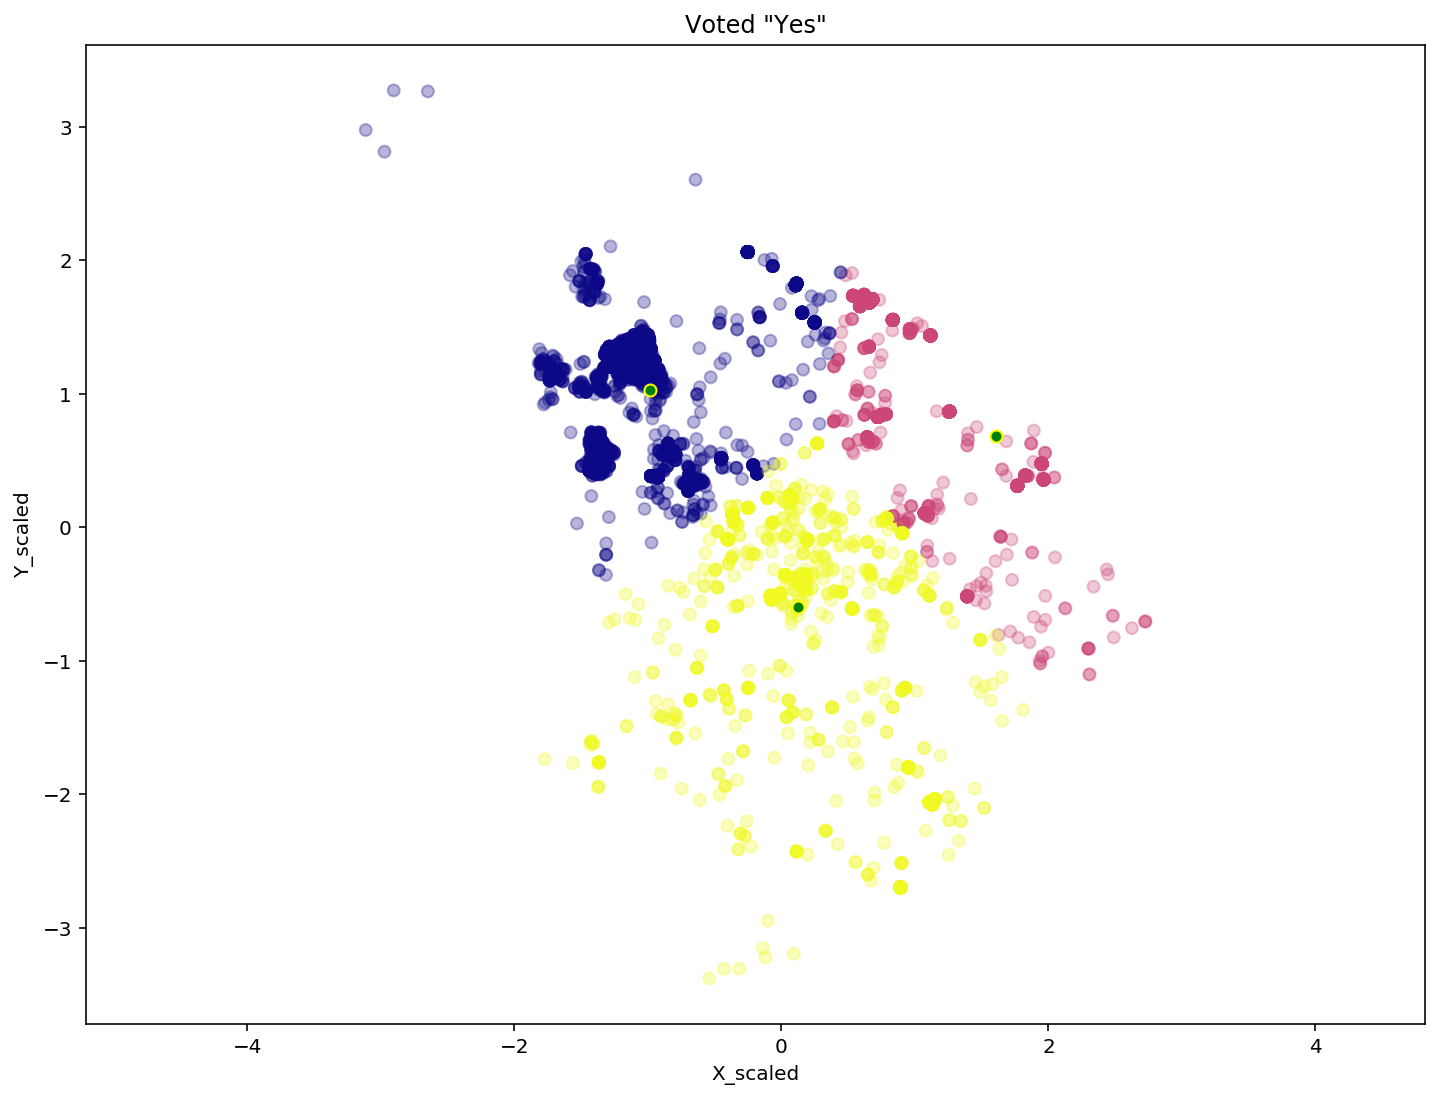

In [47]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(voted_yes['x_scaled'], voted_yes['y_scaled'],cmap='plasma',c=clusters_yes,alpha=0.3)
ax.scatter(center_yes[:,0],center_yes[:,1], c='g',edgecolors='yellow')
_=plt.axis('equal')
plt.title('Voted \"Yes\"')
plt.xlabel('X_scaled')
plt.ylabel('Y_scaled');

In [48]:
clf_Kmeans_no = KMeans(n_clusters=3)
clusters_no = clf_Kmeans_no.fit_predict(voted_no[['x_scaled','y_scaled']])
center_no = clf_Kmeans_yes.cluster_centers_

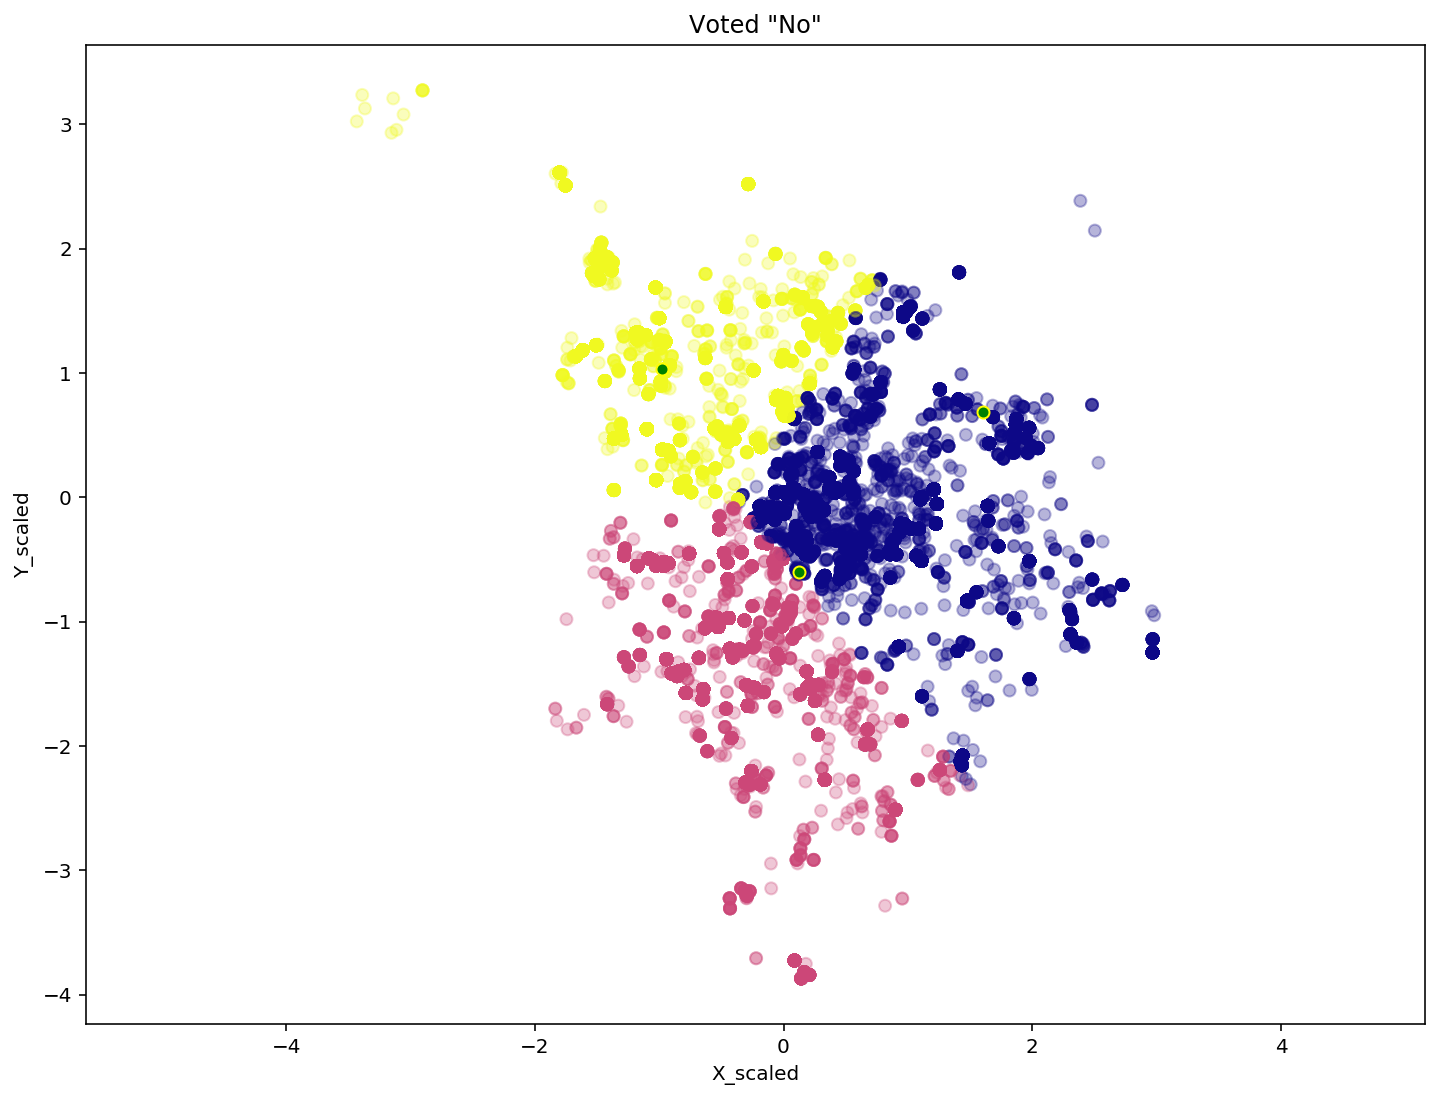

In [49]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(voted_no['x_scaled'], voted_no['y_scaled'],cmap='plasma',c=clusters_no,alpha=0.3)
ax.scatter(center_no[:,0],center_no[:,1], c='g',edgecolors='yellow')
_=plt.axis('equal')
plt.title('Voted \"No\"')
plt.xlabel('X_scaled')
plt.ylabel('Y_scaled');

## Активные в голосовании

In [50]:
dbscan = DBSCAN(eps=0.25,min_samples = 1000,n_jobs=-1)
dbscan_clusters = dbscan.fit_predict(data[['x_scaled','y_scaled']])

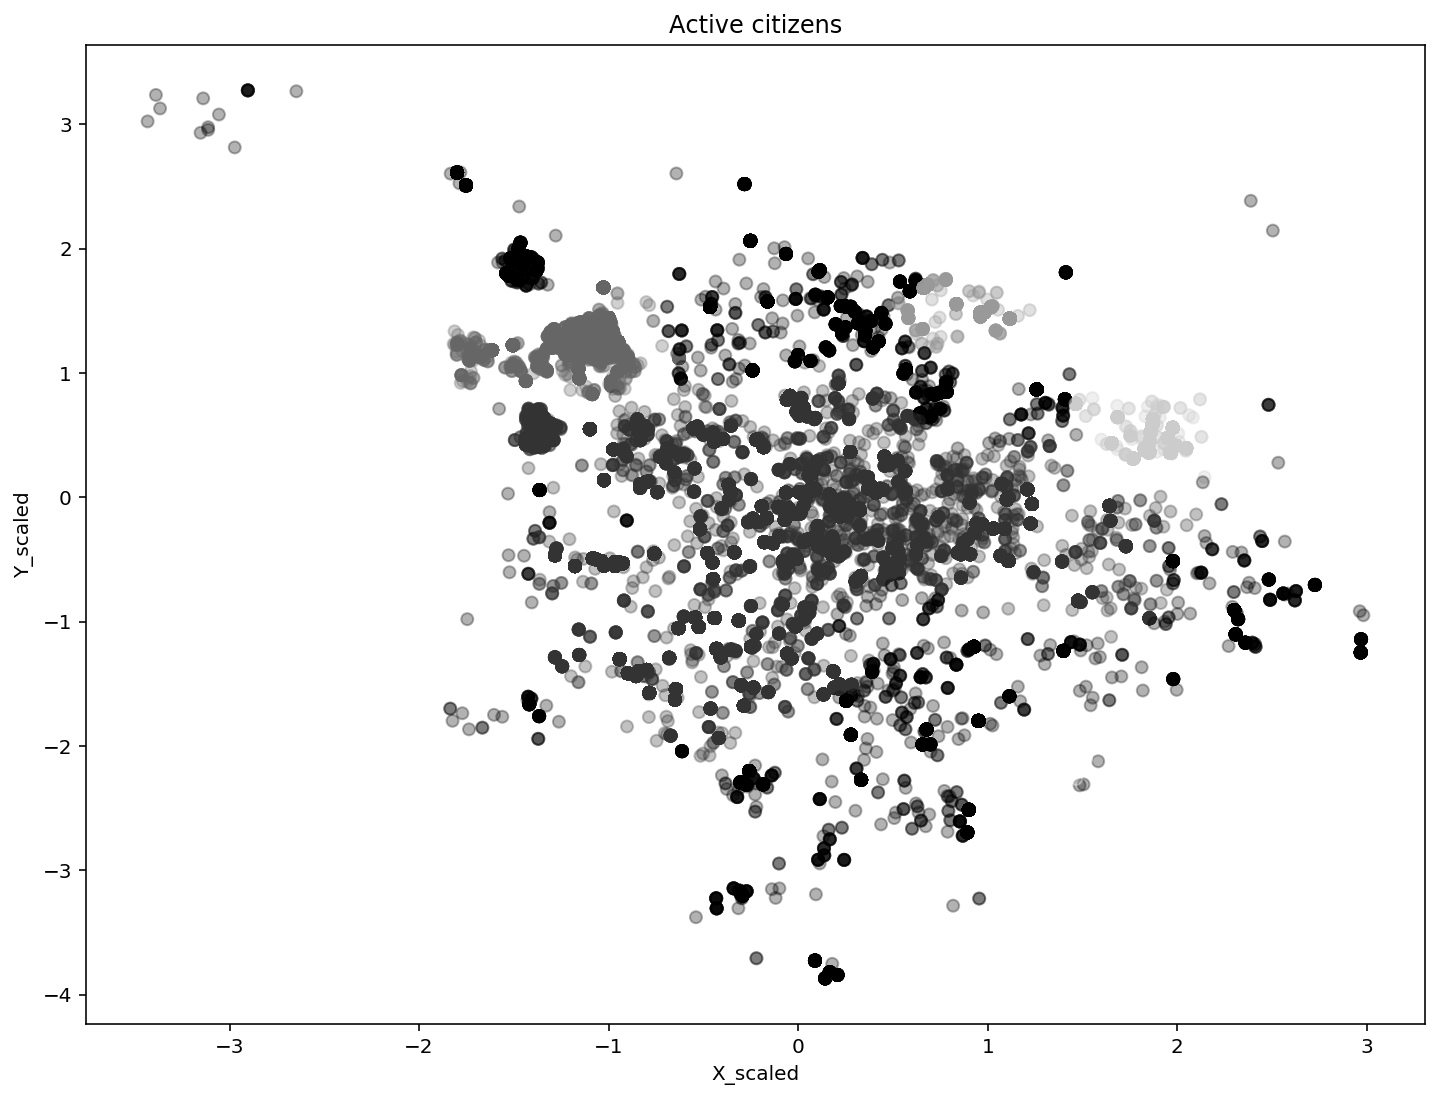

In [51]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.scatter(data['x_scaled'], data['y_scaled'],cmap='gray',c=dbscan_clusters,alpha=0.3)
plt.title('Active citizens')
plt.xlabel('X_scaled')
plt.ylabel('Y_scaled');